<a href="https://colab.research.google.com/github/Iqbal1301/iqbal/blob/main/Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=5c19033f468d59c47096409a28a97a5164dbddee47e9d186993b68b28e40de70
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType, DateType, DoubleType
from pyspark.sql.functions import split, count, when, isnan, col, regexp_replace
from pyspark.sql.functions import col
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F
import pandas as pd0
import matplotlib.pyplot as plt


In [ ]:
spark = SparkSession.builder.appName('PrediksiSaham').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [ ]:
schema = StructType([
    StructField("No", IntegerType(), True),
    StructField("Date", DateType(), True),
    StructField("Open", IntegerType(), True),
    StructField("High", IntegerType(), True),
    StructField("Low", IntegerType(), True),
    StructField("Close", IntegerType(), True),
    StructField("Volume", IntegerType(), True)])

file_path ='bbri_saham.csv'

df = spark.read.csv(file_path, header = True, inferSchema=True)

df.show(5)

+----------+----+----+----+-----+---------+
|      Date|Open|High| Low|Close|   Volume|
+----------+----+----+----+-----+---------+
|2023-12-22|5650|5700|5600| 5675|109411300|
|2023-12-21|5550|5600|5525| 5575| 99049600|
|2023-12-20|5700|5700|5550| 5550|138470900|
|2023-12-19|5450|5550|5450| 5550|158893700|
|2023-12-18|5575|5575|5500| 5500|102780900|
+----------+----+----+----+-----+---------+
only showing top 5 rows



In [ ]:
def check_missing(dataframe):
    return dataframe.select([
        count(when(col(c).isNull(), c)).alias(c)  # Only check for null values for Date
       if c == "Date" else
        count(when(isnan(c) | col(c).isNull(), c)).alias(c)  # Check for NaN and null for other columns
       for c in dataframe.columns

    ]).show()
#Check Missing Values

check_missing(df)

+----+----+----+---+-----+------+
|Date|Open|High|Low|Close|Volume|
+----+----+----+---+-----+------+
|   0|   0|   0|  0|    0|     0|
+----+----+----+---+-----+------+



In [ ]:
def handle_missing(dataframe):
    numerical_cols = dataframe.select([c for c in dataframe.columns if c != "Date"])  # Exclude Date column
    for col in numerical_cols.columns:
        dataframe = dataframe.na.fill(dataframe.select(col).mean(), col)
    return dataframe

df.show(5)

+----------+----+----+----+-----+---------+
|      Date|Open|High| Low|Close|   Volume|
+----------+----+----+----+-----+---------+
|2023-12-22|5650|5700|5600| 5675|109411300|
|2023-12-21|5550|5600|5525| 5575| 99049600|
|2023-12-20|5700|5700|5550| 5550|138470900|
|2023-12-19|5450|5550|5450| 5550|158893700|
|2023-12-18|5575|5575|5500| 5500|102780900|
+----------+----+----+----+-----+---------+
only showing top 5 rows



In [ ]:
df.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

In [ ]:
df.toPandas().head()


,Date,Open,High,Low,Close,Volume
0,2023-12-22,5650,5700,5600,5675,109411300
1,2023-12-21,5550,5600,5525,5575,99049600
2,2023-12-20,5700,5700,5550,5550,138470900
3,2023-12-19,5450,5550,5450,5550,158893700
4,2023-12-18,5575,5575,5500,5500,102780900


In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: integer (nullable = true)
 |-- High: integer (nullable = true)
 |-- Low: integer (nullable = true)
 |-- Close: integer (nullable = true)
 |-- Volume: integer (nullable = true)



In [ ]:
df.describe().show(5)

+-------+------------------+-----------------+-----------------+-----------------+--------------------+
|summary|              Open|             High|              Low|            Close|              Volume|
+-------+------------------+-----------------+-----------------+-----------------+--------------------+
|  count|               972|              972|              972|              972|                 972|
|   mean|3988.8683127572017|4391.635802469136|4289.593621399177|4337.957818930041|1.6129020113168725E8|
| stddev|1548.1044371240196|719.1309544397606|729.4332933408243| 726.744976477158| 9.568202638379899E7|
|    min|                 0|             2270|             2160|             2170|             6819800|
|    max|              5700|             5750|             5675|             5700|           872607300|
+-------+------------------+-----------------+-----------------+-----------------+--------------------+



In [ ]:
df.describe(['Open', 'Close']).show()

+-------+------------------+-----------------+
|summary|              Open|            Close|
+-------+------------------+-----------------+
|  count|               972|              972|
|   mean|3988.8683127572017|4337.957818930041|
| stddev|1548.1044371240196| 726.744976477158|
|    min|                 0|             2170|
|    max|              5700|             5700|
+-------+------------------+-----------------+



In [ ]:
#describe with numerical columns
def get_num_cols(dataframe):

    num_cols = [col for col in dataframe.columns if dataframe.select(col). \
                dtypes[0][1] in ['double', 'int']]

    return num_cols

num_cols = get_num_cols(df)

df.describe(num_cols).show()

+-------+------------------+-----------------+-----------------+-----------------+--------------------+
|summary|              Open|             High|              Low|            Close|              Volume|
+-------+------------------+-----------------+-----------------+-----------------+--------------------+
|  count|               972|              972|              972|              972|                 972|
|   mean|3988.8683127572017|4391.635802469136|4289.593621399177|4337.957818930041|1.6129020113168725E8|
| stddev|1548.1044371240196|719.1309544397606|729.4332933408243| 726.744976477158| 9.568202638379899E7|
|    min|                 0|             2270|             2160|             2170|             6819800|
|    max|              5700|             5750|             5675|             5700|           872607300|
+-------+------------------+-----------------+-----------------+-----------------+--------------------+



In [ ]:
df.filter(df['Open'] > 5300).show(5)

+----------+----+----+----+-----+---------+
|      Date|Open|High| Low|Close|   Volume|
+----------+----+----+----+-----+---------+
|2023-12-22|5650|5700|5600| 5675|109411300|
|2023-12-21|5550|5600|5525| 5575| 99049600|
|2023-12-20|5700|5700|5550| 5550|138470900|
|2023-12-19|5450|5550|5450| 5550|158893700|
|2023-12-18|5575|5575|5500| 5500|102780900|
+----------+----+----+----+-----+---------+
only showing top 5 rows



In [ ]:
df.filter((df['Open'] > 5500 ) & (df['Close'] == 5600)). \
orderBy('Open', ascending = False).show(5)
# Memfilter Harga Saham Open dan Close, dan urutkan berdasarkan Harga yang ditentukan

+----------+----+----+----+-----+---------+
|      Date|Open|High| Low|Close|   Volume|
+----------+----+----+----+-----+---------+
|2023-08-23|5600|5625|5575| 5600| 78686900|
|2023-07-24|5600|5650|5600| 5600| 62962500|
|2023-08-25|5550|5600|5525| 5600| 65096500|
|2023-08-29|5525|5600|5525| 5600| 57547200|
|2023-05-24|5525|5600|5450| 5600|156211500|
+----------+----+----+----+-----+---------+



In [ ]:
df.filter('Open == 5600 and Close between 5600 and 5750 ') \
.select(['Open', 'Close', 'High']).show()

+----+-----+----+
|Open|Close|High|
+----+-----+----+
|5600| 5625|5625|
|5600| 5600|5625|
|5600| 5700|5725|
|5600| 5600|5650|
|5600| 5625|5625|
+----+-----+----+



In [ ]:
df.groupBy('Open').agg({'Close' : 'min'}).show(5)

+----+----------+
|Open|min(Close)|
+----+----------+
|5300|      5225|
|4900|      4800|
|4190|      3980|
|3220|      3190|
|4000|      3880|
+----+----------+
only showing top 5 rows



In [ ]:
df.groupBy('Open').agg({'Close': 'max'}).show(5)

+----+----------+
|Open|max(Close)|
+----+----------+
|5300|      5425|
|4900|      4930|
|4190|      4230|
|3220|      3300|
|4000|      4160|
+----+----------+
only showing top 5 rows



In [ ]:
#Check brand frequences first
df.groupby('Close').count().orderBy('count', ascending = False).show(5)

+-----+-----+
|Close|count|
+-----+-----+
| 4400|   18|
| 4650|   13|
| 4250|   12|
| 5550|   12|
| 4280|   11|
+-----+-----+
only showing top 5 rows



In [ ]:
def one_hot_encoder(dataframe, col):

    indexed = StringIndexer().setInputCol(col).setOutputCol(col + '_cat'). \
    fit(dataframe).transform(dataframe) #converting categorical values into category indices

    ohe = OneHotEncoder().setInputCol(col + '_cat').setOutputCol(col + '_OneHotEncoded'). \
    fit(indexed).transform(indexed)

    ohe = ohe.drop(*[col, col + '_cat'])

    return ohe

df = one_hot_encoder(df, col = 'Volume')
df.show(5)

+----------+----+----+----+-----+--------------------+
|      Date|Open|High| Low|Close|Volume_OneHotEncoded|
+----------+----+----+----+-----+--------------------+
|2023-12-22|5650|5700|5600| 5675|    (971,[75],[1.0])|
|2023-12-21|5550|5600|5525| 5575|   (971,[966],[1.0])|
|2023-12-20|5700|5700|5550| 5550|   (971,[254],[1.0])|
|2023-12-19|5450|5550|5450| 5550|   (971,[356],[1.0])|
|2023-12-18|5575|5575|5500| 5500|    (971,[15],[1.0])|
+----------+----+----+----+-----+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

def vector_assembler(dataframe, indep_cols=['High', 'Open', 'Low']):
    assembler = VectorAssembler(inputCols=indep_cols, outputCol='features')
    output = assembler.transform(dataframe)
    return output



    indep_cols = ['High', 'Open', 'Low']

df = vector_assembler(df)
df.show(5)

+----------+----+----+----+-----+--------------------+--------------------+
|      Date|Open|High| Low|Close|Volume_OneHotEncoded|            features|
+----------+----+----+----+-----+--------------------+--------------------+
|2023-12-22|5650|5700|5600| 5675|    (971,[75],[1.0])|[5700.0,5650.0,56...|
|2023-12-21|5550|5600|5525| 5575|   (971,[966],[1.0])|[5600.0,5550.0,55...|
|2023-12-20|5700|5700|5550| 5550|   (971,[254],[1.0])|[5700.0,5700.0,55...|
|2023-12-19|5450|5550|5450| 5550|   (971,[356],[1.0])|[5550.0,5450.0,54...|
|2023-12-18|5575|5575|5500| 5500|    (971,[15],[1.0])|[5575.0,5575.0,55...|
+----------+----+----+----+-----+--------------------+--------------------+
only showing top 5 rows



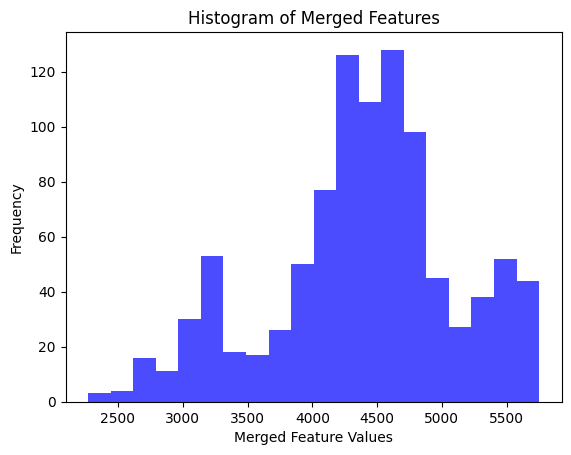

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data yang telah di-VectorAssembler
feature_data = df.select('features').collect()

# Konversi kolom fitur ke dalam bentuk numpy array
features_array = np.array([float(row.features[0]) for row in feature_data])

# Visualisasi Histogram
plt.hist(features_array, bins=20, color='blue', alpha=0.7)
plt.xlabel('Merged Feature Values')
plt.ylabel('Frequency')
plt.title('Histogram of Merged Features')
plt.show()


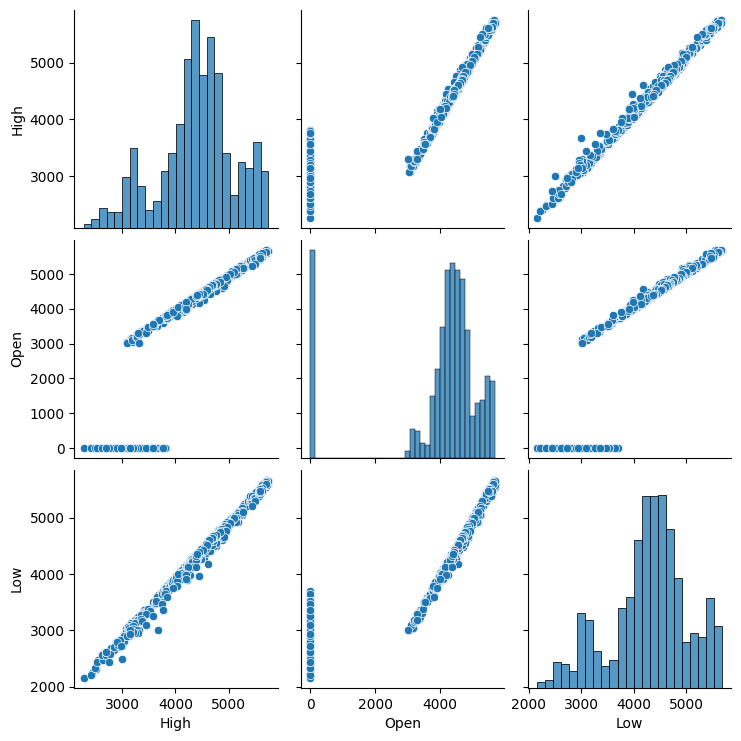

In [ ]:
import seaborn as sns
import pandas as pd

# Ambil data yang telah di-VectorAssembler dan diubah ke dalam Pandas DataFrame
feature_data_pd = df.select('features').toPandas()

# Pisahkan kolom fitur ke dalam kolom terpisah
split_features = pd.DataFrame(feature_data_pd['features'].tolist(), columns=['High', 'Open', 'Low'])

# Tambahkan kolom target jika ada
# split_features['Target'] = df.select('Target').collect()

# Visualisasi Pair Plot
sns.pairplot(split_features)
plt.show()


In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2])

print('Train shape: ({}, {})'.format(train_data.count(),len(train_data.columns)))
print('Test shape: ({},{})'.format(test_data.count(), len(test_data.columns)))

In [ ]:
lr = LinearRegression(labelCol="Close", featuresCol="features", regParam=0.3)

lr = lr.fit(train_data)

In [ ]:
def evaluate_reg_model(model, test_data):

    print(model.__class__.__name__.center(70, '-'))
    model_results = model.evaluate(test_data)
    print('R2: {}'.format(model_results.r2))
    print('MSE: {}'.format(model_results.meanSquaredError))
    print('RMSE: {}'.format(model_results.rootMeanSquaredError))
    print('MAE: {}'.format(model_results.meanAbsoluteError))
    print(70*'-')

evaluate_reg_model(lr, test_data)

------------------------LinearRegressionModel-------------------------
R2: 0.9964295194151406
MSE: 1844.8675409644648
RMSE: 42.951921272097536
MAE: 31.329481792198802
----------------------------------------------------------------------


In [ ]:
#End Session
spark.stop()